# just vanilla DQN, no DDQN

In [1]:
import gymnasium as gym
import numpy as np
from IPython.display import display, clear_output, Image
import time
# from PIL import Image
from collections import deque
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

In [14]:
# env = gym.make('LunarLander-v3', render_mode='rgb_array')
env = gym.make('LunarLander-v3', render_mode='human')
# env = env.unwrapped

def render_frame(env):
    frame = env.render()
    # image = Image.fromarray(frame)
    # display(image)
    
state, info = env.reset()
render_frame(env)

In [3]:
print(env.action_space)
print(env.observation_space.shape)

Discrete(4)
(8,)


In [4]:
env.unwrapped.render_mode = 'human'

state, info = env.reset()
for step in range(999):
    clear_output(wait=True)
    render_frame(env)

    action = env.action_space.sample()
    state, reward, done, truncated, info = env.step(action)
    print('taking action', action, ' got reward', reward)

    if done or truncated:
        print(f"Episode finished with environment reward: {reward}")
        break

taking action 3  got reward -100
Episode finished with environment reward: -100


In [5]:
# action idx mapping, 0:NOOP 1:left 2:main 3:right
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 64)  # fully connected layers
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 4)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # raw logits are predicted Q values
        return x
        

# create a TargetQNet as well for stability
# QNet will be copied into TargetQNet periodically (maybe every 1000 steps)
QNet = Network()  # updated every step
TargetQNet = Network()  # produces targets that are used to update QNet

def sync(): 
    TargetQNet.load_state_dict(QNet.state_dict())
    
def soft_sync(tau):
    if tau == 1:
        sync()
        return
    for target_param, q_param in zip(TargetQNet.parameters(), QNet.parameters()):
        target_param.data.copy_(tau*q_param.data + (1-tau)*target_param.data)

sync()

In [6]:
def epsilon_greedy(eps):
    if np.random.random() < eps:
        return env.action_space.sample()  # random action with prob epsilon
    with torch.no_grad():  # don't track backward gradients on inference
        x = torch.tensor(state)
        q_values = QNet(x)  # same as QNet.forward(x)
        return q_values.argmax().item()  # greedy action

In [7]:
gamma = 0.998      # discount factor
buf_sz = 100_000   # max capacity of replay buffer
learn_freq = 4     # do a learning update every X steps
sync_freq = 16     # sync the target network with the Q network every X steps
batch_sz = 64      # mini-batch size
min_buf_sz = 1000  # start training after X samples are in replay buffer
max_steps = 9999   # truncate env if it ever reaches X time steps (keeps episode times resonable)
tau = 0.005        # soft target network update percentage, set to 1 for hard update

optimizer = optim.AdamW(QNet.parameters(), lr=0.001)  # optimizer choice and learning rate
L = nn.MSELoss()  # loss, probably MSE is best, note that MSELoss calculates mean element-wise diffs

# epsilon-greedy linear annealing
eps_max = 1    # start
eps_min = 0.10 # final
eps_anneal_steps = 150000  # decay over X steps

action_repeat = 2  # value of >1 implements idea from 2013 and 2015 deepmind papers to repeat actions to save computation
                   # e.g. a value of 4 means the agent will only see every 4th frame and each action it selects is repeated 4 times

episode 2990	(6.3/s)
steps 1226676	(2587/s)
time 474.25 s
---
epsilon 0.10
replay buffer size 100000


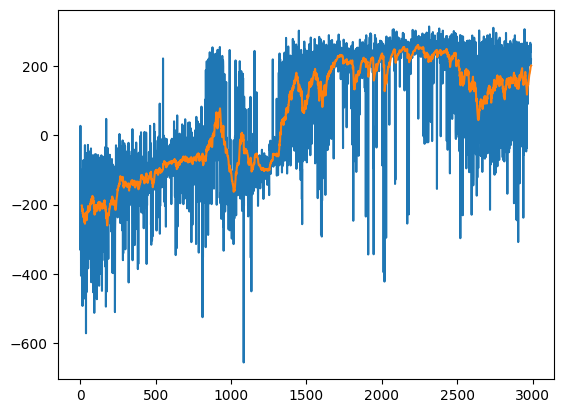

In [8]:
replay_buf = deque(maxlen=buf_sz) # 5-tuple (state, action, reward, next_state, done)

env.unwrapped.render_mode = None

while len(replay_buf) < min_buf_sz:
    clear_output(wait=True)
    print(f'collect initial training data {len(replay_buf)}/{min_buf_sz}')
    
    state, info = env.reset()
    while True:
        reward = 0
        for rep in range(action_repeat):
            next_state, frame_reward, done, truncated, info = env.step(action)
            reward += frame_reward
            if done or truncated: break
        replay_buf.append((state, action, reward, next_state, done))
        if done or truncated: break

    
t0 = time.time()
total_steps = 0

return_history = []
avg_history = []  # moving average of return
avg_beta = 0.95

for episode in range(3000):
    state, info = env.reset()
    return_ = 0
    steps = 0
    while True:
        eps = max(eps_min, eps_min + (eps_max - eps_min) * (1 - total_steps/eps_anneal_steps))
        action = epsilon_greedy(eps)

        reward = 0
        for rep in range(action_repeat):
            steps += 1
            total_steps += 1
            next_state, frame_reward, done, truncated, info = env.step(action)
            reward += frame_reward
            if done or truncated: break  # don't want to accumulate eroneous rewards at end of episode
        
        if steps > max_steps: truncated = True  # 'truncated' not 'done' so it doesn't corrupt replay buffer!!
        replay_buf.append((state, action, reward, next_state, done))
        return_ += reward

        if total_steps % sync_freq == 0: 
            soft_sync(tau)  # update the target network

        if len(replay_buf) >= min_buf_sz and total_steps % learn_freq == 0:
            batch = random.sample(replay_buf, batch_sz)  # remember, this is a batch of many 5-tuples
            states, actions, rewards, next_states, dones = zip(*batch)  # unpack, pack, unpack into desired vars
            
            states_tensor = torch.tensor(states, dtype=torch.float)                   # shape (m, |S|) where m=batch_sz
            actions_tensor = torch.tensor(actions, dtype=torch.float).reshape(-1, 1)  # shape (m, 1)
            rewards_tensor = torch.tensor(rewards, dtype=torch.float).reshape(-1, 1)  # shape (m, 1)
            next_states_tensor = torch.tensor(next_states, dtype=torch.float)         # shape (m, |S|)
            dones_tensor = torch.tensor(dones, dtype=torch.float).reshape(-1, 1)      # shape (m, 1)

            # forward pass outputs includes Q values for all actions but we only observe the choosen action, so gather along columns
            Q_pred = QNet(states_tensor).gather(1, actions_tensor.type(torch.LongTensor))  # gather needs LongTensor to work

            with torch.no_grad():  # disable backward gradient tracking since we never backprop on the target network
                selected_target_Q = TargetQNet(next_states_tensor).max(dim=1, keepdim=True)[0]  # max Q-value from TargetQNet
                # If non-terminal  y = R(s) + gamma * max_a' Q_target(s', a')
                # If terminal      y = R(s)  [handled by factor of (1 - dones_tensor)]
                y = rewards_tensor + gamma * selected_target_Q * (1 - dones_tensor)                
                
            loss = L(Q_pred, y.detach())  # oops, forgot to detach grads here, do you have to?
            
            optimizer.zero_grad()
            loss.backward()
            # nn.utils.clip_grad_norm_(QNet.parameters(), max_norm=1.0)  # clip grads - maybe not necessary
            optimizer.step()
            
        state = next_state
        if done or truncated: break
        
    return_history.append(return_)
    if not avg_history: avg_history.append(return_)  # initialize with 1 element
    avg_history.append(avg_history[-1] * avg_beta + (1-avg_beta) * return_)
    
    if episode % 10 == 0:
        t = time.time() - t0
        clear_output(wait=True)
        print(f'episode {episode}\t({episode/t :.1f}/s)')
        print(f'steps {total_steps}\t({total_steps/t :.0f}/s)')
        print(f'time {t:.2f} s')
        print('---')
        print(f'epsilon {eps:.2f}')
        print(f'replay buffer size {len(replay_buf)}')
        
        plt.plot(return_history)
        xs = range(10, len(avg_history))  # delay avg start
        plt.plot(xs, avg_history[10:])
        plt.show()

episode 500	(18.9/s)
steps 222374	(8423/s)
time 26.40 s
average return 225.95


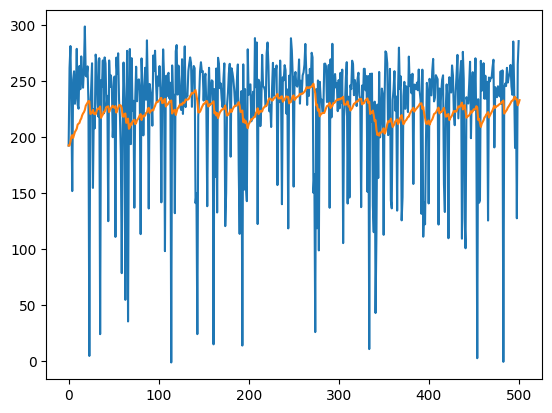

In [9]:
# evaluate the model (setting epsilon to 0)

env.unwrapped.render_mode = None
return_history = []
avg_history = []  # moving average of return
avg_beta = 0.95

t0 = time.time()
total_steps = 0

for episode in range(501):
    state, info = env.reset()
    steps = 0
    return_ = 0
    while True:
        action = epsilon_greedy(0)

        reward = 0
        for rep in range(action_repeat):
            steps += 1
            total_steps += 1
            state, frame_reward, done, truncated, info = env.step(action)
            reward += frame_reward
            if done or truncated: break  # don't want to accumulate eroneous rewards at end of episode
        if steps > max_steps: truncated = True
            
        return_ += reward
        if done or truncated: break

    return_history.append(return_)
    if not avg_history: avg_history.append(return_)  # initialize with 1 element
    avg_history.append(avg_history[-1] * avg_beta + (1-avg_beta) * return_)
    
    if episode % 10 == 0:
        t = time.time() - t0
        clear_output(wait=True)
        print(f'episode {episode}\t({episode/t :.1f}/s)')
        print(f'steps {total_steps}\t({total_steps/t :.0f}/s)')
        print(f'time {t:.2f} s')
        print(f'average return {np.mean(return_history):.2f}')
        
        plt.plot(return_history)
        plt.plot(avg_history)
        plt.show()

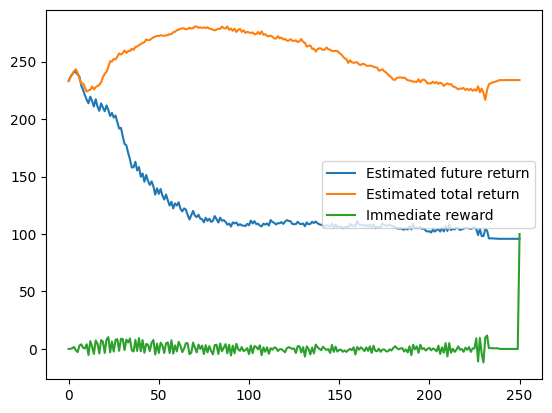

Episode finished with environment reward: 100.00000027522799, total rewards collected: 238.08956622508484


In [15]:
# play out an episode with stats!

env.unwrapped.render_mode = 'human'

Q_history = []
reward_history = []
estimated_total_return = []

_cumsum = 0
state, info = env.reset()
for step in range(99999):
    render_frame(env)

    with torch.no_grad():
        x = torch.tensor(state)
        q_values = QNet(x)
        action = q_values.argmax().item()  # this action is same as calling epsilon_greedy(eps=0)
        max_Q = q_values.max().item()

    reward = 0
    for rep in range(action_repeat):
        state, frame_reward, done, truncated, info = env.step(action)
        reward += frame_reward
        if done or truncated: break

    Q_history.append(max_Q)
    reward_history.append(reward)
    estimated_total_return.append(_cumsum + max_Q)
    _cumsum += reward

    if step % 1 == 0:
        clear_output(wait=True)
        plt.plot(Q_history, label='Estimated future return')
        plt.plot(estimated_total_return, label='Estimated total return')
        plt.plot(reward_history, label='Immediate reward')
        plt.legend()
        plt.show()

    if done or truncated:
        print(f"Episode finished with environment reward: {reward}, total rewards collected: {_cumsum}")
        break

In [11]:
# save
# torch.save(QNet.state_dict(), 'lunarLander-QNet-2k.pth')

In [16]:
env.close()